In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import warnings

warnings.filterwarnings(
    "ignore",
    message="plotting functions contained within `_documentation_utils` are intended for nemos's documentation.",
    category=UserWarning,
)

:::{admonition} Download
:class: important render-all

This notebook can be downloaded as **{nb-download}`03_calcium_imaging_analysis.ipynb`**. See the button at the top right to download as markdown or pdf.
:::


# Calcium imaging analysis of head-direction cells

We will analyze calcium imaging data of head-direction cells recorded in the postsubiculum of the mouse.
The goal of this group project is to learn how to use pynapple to analyze calcium imaging data and fit a GLM to it using nemos.
We will use a NWB file containing deconvolved calcium events of neurons and the head-direction of the animal over time.
We will study the tuning properties of neurons with tuning curves.


The pynapple documentation can be found [here](https://pynapple.org).

The nemos documentation can be found [here](https://nemos.readthedocs.io/en/latest/).


## Part 1 : Analyzing calcium imaging with pynapple

<div class="render-all">

For this part of the group project, we will use pynapple to do the following tasks:
1. Loading a NWB file
2. Compute tuning curves
3. Visualize tuning curves
4. Decode head-direction from neural activity


Let's start by importing the necessary libraries and fetching the data.
</div>

In [2]:
import workshop_utils
import pynapple as nap
import matplotlib.pyplot as plt
import numpy as np
import nemos as nmo
import jax

# LBFGS works better with float64 precision
jax.config.update("jax_enable_x64", True)

# some helper plotting functions
from nemos import _documentation_utils as doc_plots

# configure pynapple to ignore conversion warning
nap.nap_config.suppress_conversion_warnings = True

# configure plot style
plt.style.use(nmo.styles.plot_style)

# fetch data
path = workshop_utils.fetch_data("A0670-221213.nwb")
print(path)

/home/agent/workspace/rorse_ccn-software-feb-2026_main/data/A0670-221213.nwb


### Load data

<div class="render-all">

Similar to part 1, we will start by loading the NWB file. The function `nap.load_file` can be used again.

</div>

<div class="render-user">
```{code-cell} ipython3
data = ... # Load NWB file
print(data)
```
</div>

In [3]:
data = nap.load_file(path)

print(data)

A0670-221213
┍━━━━━━━━━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━┑
│ Keys                  │ Type        │
┝━━━━━━━━━━━━━━━━━━━━━━━┿━━━━━━━━━━━━━┥
│ position_time_support │ IntervalSet │
│ RoiResponseSeries     │ TsdFrame    │
│ z                     │ Tsd         │
│ y                     │ Tsd         │
│ x                     │ Tsd         │
│ rz                    │ Tsd         │
│ ry                    │ Tsd         │
│ rx                    │ Tsd         │
┕━━━━━━━━━━━━━━━━━━━━━━━┷━━━━━━━━━━━━━┙


<div class="render-all">

There are multiple entries in the NWB file. The calcium transients are stored in the `RoiResponseSeries` entry.
The head-direction of the animal is stored in the `ry` entry. Let's extract them.

</div>

In [4]:
transients = data["RoiResponseSeries"]
angle = data["ry"]
print(transients)

Time (s)          0        1         2         3         4  ...
----------  -------  -------  --------  --------  --------  -----
3.1187      0.27546  0.79973  0.16383   0.20118   0.029255  ...
3.15225     0.26665  0.86751  0.15879   0.23682   0.027189  ...
3.18585     0.25796  0.89419  0.15352   0.25074   0.036514  ...
3.2194      0.24943  0.89513  0.14812   0.25215   0.056273  ...
3.253       0.24111  0.88023  0.14898   0.24651   0.070954  ...
3.28655     0.233    0.85584  0.14858   0.23706   0.081469  ...
3.32015     0.22513  1.0996   0.14715   0.22572   0.088588  ...
...                                                         ...
1203.38945  0.20815  0.17535  0.12126   0.094461  0.87427   ...
1203.42305  0.20247  0.17243  0.11807   0.089918  1.2578    ...
1203.4566   0.19654  0.17056  0.11461   0.085079  1.62      ...
1203.4902   0.19052  0.16645  0.11096   0.080197  1.8811    ...
1203.52375  0.18449  0.16105  0.10717   0.075416  2.0599    ...
1203.55735  0.17851  0.15494  0.10331 

<div class="render-all">

To get an idea of the data, let's visualize the calcium transients of the first two neurons for the first 100 seconds of the recording.
Instead of creating a new `IntervalSet` object, we can use the method `transients.get(0, 100)` to get a restricted version of the `Tsd` object.
Contrary to `restrict`, which takes an `IntervalSet` object as input, `get` can take start and end times directly as input and does not 
update the time support of the output `Tsd` object.

</div>

Text(0, 0.5, 'Fluorescence (a.u.)')

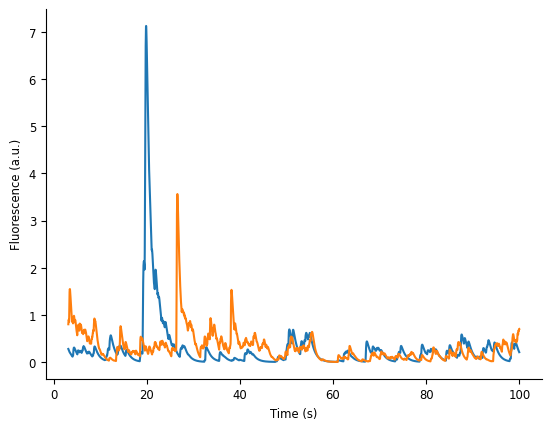

In [5]:
fig = plt.figure()
plt.plot(transients[:,0:2].get(0, 100))
plt.xlabel("Time (s)")
plt.ylabel("Fluorescence (a.u.)")

In [6]:
fig.savefig("../../_static/_check_figs/01-04.png")

<div class="render-user">
:::{admonition} Figure check
:class: dropdown
![](../../_static/_check_figs/01-04.png)
:::
</div>

### Compute tuning curves

<div class="render-all">

Now we have 
- calcium transients
- a behavioral feature (i.e. head-direction),
We can compute tuning curves, i.e. the fluorescence of neurons as a function of head-direction. 
We want to know how the fluorescence of each neuron changes as a function of the head-direction of the animal.
We can use the same function as before : `nap.compute_tuning_curves`. 
Don't forget to give a name to the feature when calling the function (i.e. `feature_names = ["angle"]`).

</div>

<div class="render-user">
```{code-cell} ipython3
tuning_curves = nap.compute_tuning_curves(
    data=, # The neural activity as a TsGroup
    features=, # Which feature? Here the head-direction of the animal
    bins=, # How many bins of feature space? Here 61 angular bins is a good numbers 
    range=, # The min and max of the bin array
    feature_names =  # Let's give a name to our feature for better labelling of the output.
    ) 
tuning_curves
```
</div>

In [7]:
tuning_curves = nap.compute_tuning_curves(
    data=transients,
    features=angle, 
    bins=61, 
    epochs = angle.time_support,
    range=(0, 2 * np.pi),
    feature_names = ["angle"]
    )
tuning_curves

<xarray.DataArray (unit: 65, angle: 61)> Size: 32kB
array([[0.336294  , 0.39249376, 0.28825878, ..., 0.36234269, 0.2708909 ,
        0.28310301],
       [0.05395929, 0.04359246, 0.04214995, ..., 0.07306646, 0.06231189,
        0.05681652],
       [0.15342062, 0.17939499, 0.15450186, ..., 0.1853742 , 0.11779423,
        0.12548764],
       ...,
       [0.09231561, 0.09080612, 0.06466286, ..., 0.13556026, 0.1133827 ,
        0.09577019],
       [0.10206325, 0.08374734, 0.07383455, ..., 0.11335814, 0.10032206,
        0.09266054],
       [0.09586888, 0.13690644, 0.16440948, ..., 0.0797701 , 0.08365685,
        0.0929572 ]], shape=(65, 61))
Coordinates:
  * unit     (unit) int64 520B 0 1 2 3 4 5 6 7 8 ... 56 57 58 59 60 61 62 63 64
  * angle    (angle) float64 488B 0.0515 0.1545 0.2575 ... 6.026 6.129 6.232
Attributes:
    occupancy:  [1898. 2249. 2064. 1962. 2081. 2249. 2544. 2511. 2045. 2498. ...
    bin_edges:  [array([0.        , 0.10300304, 0.20600608, 0.30900911, 0.412...
    fs:         120.00514660424693

### Visualize tuning curves

Let's visualize the tuning curves of the first two neurons.

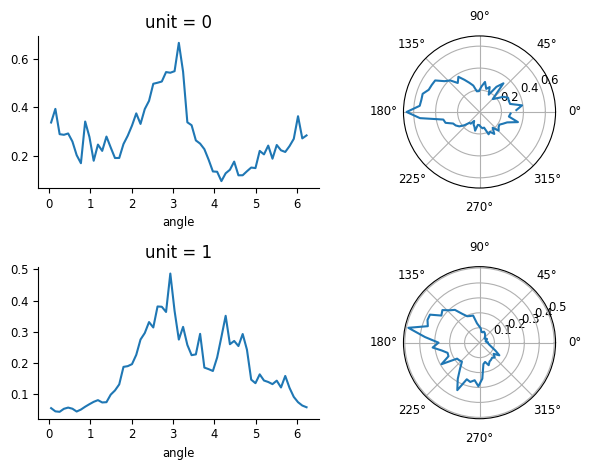

In [8]:
fig = plt.figure()
plt.subplot(221)
tuning_curves[0].plot()
plt.subplot(222,projection='polar')
plt.plot(tuning_curves.angle, tuning_curves[0].values)
plt.subplot(223)
tuning_curves[1].plot()
plt.subplot(224,projection='polar')
plt.plot(tuning_curves.angle, tuning_curves[1].values)
plt.tight_layout()

In [9]:
fig.savefig("../../_static/_check_figs/01-05.png")

<div class="render-user">
:::{admonition} Figure check
:class: dropdown
![](../../_static/_check_figs/01-05.png)
:::
</div>



### Decode head-direction from neural activity

<div class="render-all">

Now that we have the tuning curves, we can use them to decode the head-direction of the animal from the neural activity.
Pynapple provides two functions to do this: `nap.decode_bayes` for spike counts and `nap.decode_template` for event rates or continuous data. 
Since the data are calcium transients and not spike counts, we will use the template matching method.

**Question:** Can you decode the head-direction of the animal using the function `nap.decode_template` and call the variable `decoded_angle`?

We will us the epoch `epochs = nap.IntervalSet([50, 150])` to restrict the decoding to the first 100 seconds of the recording.

</div>

<div class="render-user">
```{code-cell} ipython3
epochs = nap.IntervalSet(start=50, end=150)
decoded_angle, dist = nap.decode_template(
    tuning_curves=..., # The tuning curves as an xarray object
    data=..., # The neural activity as a TsdFrame in this case
    bin_size=..., # The bin size for decoding. Here I suggest 0.1 second
    metric=... # The metric to use to compare the neural activity to the tuning curves. Here I suggest "correlation"
    epochs=transients.time_support # The epochs should correspond to when the neural activity is defined. Here we use the time support directly
    )
```
</div>

In [10]:
epochs = nap.IntervalSet(start=50, end=150)
decoded_angle, dist = nap.decode_template(
    tuning_curves=tuning_curves,
    data=transients,
    bin_size=0.1,
    metric="correlation",
    epochs=epochs    
    )

/home/agent/workspace/rorse_ccn-software-feb-2026_main/.venv/lib/python3.12/site-packages/pynapple/process/decoding.py:48: UserWarning: passed bin_size is different from actual data bin size.
  warnings.warn("passed bin_size is different from actual data bin size.")


<div class="render-all">
Let's visualize the decoded head-direction of the animal for the first 100 seconds of the recording.
</div>

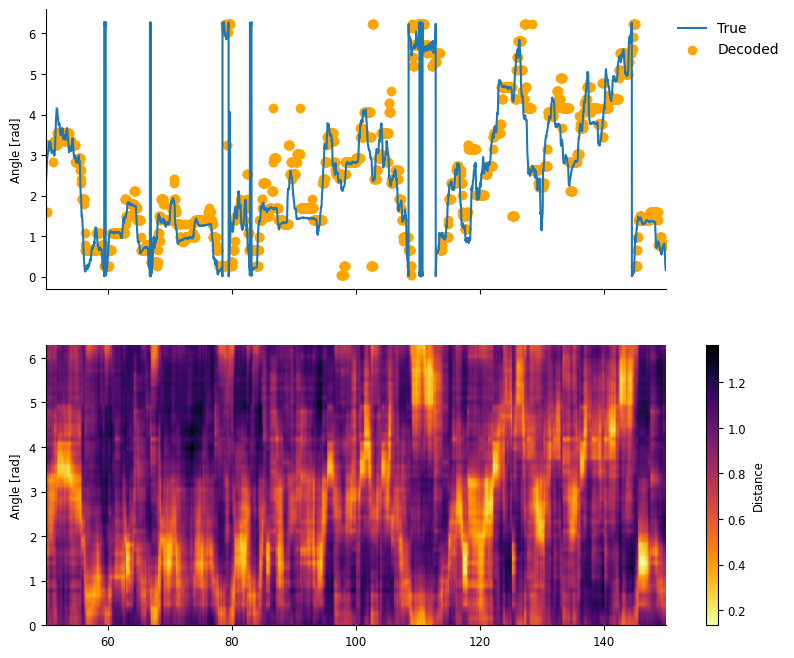

In [11]:
fig, (ax1, ax2) = plt.subplots(figsize=(8, 8), nrows=2, ncols=1, sharex=True)
ax1.plot(angle.restrict(epochs), label="True")
ax1.scatter(decoded_angle.times(), decoded_angle.values, label="Decoded", c="orange")
ax1.legend(frameon=False, bbox_to_anchor=(1.0, 1.0))
ax1.set_ylabel("Angle [rad]")

im = ax2.imshow(
    dist.values.T, 
    aspect="auto", 
    origin="lower", 
    cmap="inferno_r", 
    extent=(epochs.start[0], epochs.end[0], 0.0, 2*np.pi)
)
ax2.set_ylabel("Angle [rad]")
cbar_ax2 = fig.add_axes([0.95, ax2.get_position().y0, 0.015, ax2.get_position().height])
fig.colorbar(im, cax=cbar_ax2, label="Distance")


In [12]:
fig.savefig("../../_static/_check_figs/01-06.png")

<div class="render-user">
:::{admonition} Figure check
:class: dropdown
![](../../_static/_check_figs/01-06.png)
:::
</div>


<div class="render-all">

The first panel shows the true head-direction of the animal and the decoded head-direction from neural activity.
The second panel shows the distance between the neural activity and the tuning curves as a function of time and angle.

You can play with the metric parameters of the decoding function to see how it affects the decoding performance. 
Possible metrics are "euclidean", "manhattan", "correlation", "jensenshannon" and "cosine". 

</div>


## Part 2 : Modelling calcium imaging data with GLM

In this part we will fit a GLM to calcium imaging data. Calcium imaging data has different characteristics compared to extracellular spike data.
First, the data is continuous-valued, representing fluorescence intensity, rather than discrete spike counts.
Second, calcium signals have slower dynamics due to the kinetics of calcium indicators.
Therefore, we will use a different observation model instead of a Poisson model, and we will adjust the basis functions to capture the slower dynamics.

### Preprocessing the data

<div class="render-all">

To speed up the analysis, the following code computes a Rayleigh test to select only neurons that are significantly tuned to head-direction.

</div>

In [13]:
C = np.sum(tuning_curves.values * np.cos(tuning_curves.angle.values), axis=1) / np.sum(tuning_curves.values, axis=1)
S = np.sum(tuning_curves.values * np.sin(tuning_curves.angle.values), axis=1) / np.sum(tuning_curves.values, axis=1)
R = np.sqrt(C**2 + S**2)
Z = tuning_curves.shape[1] * R**2
p_value = np.exp(-Z)

tokeep_neurons = np.where(p_value < 0.01)[0]
transients = transients[:, tokeep_neurons]
tuning_curves = tuning_curves[tokeep_neurons]
print(f"Number of neurons after tuning selection: {transients.shape[1]}")

Number of neurons after tuning selection: 16


<div class="render-all">

Finally, we sort the neurons based on their preferred head-direction.

</div>

In [14]:
pref_ang = tuning_curves.idxmax(dim="angle")
sort_idx = np.argsort(pref_ang.values)
transients = transients[:, sort_idx]
tuning_curves = tuning_curves[sort_idx]
pref_ang = pref_ang[sort_idx]
transients.set_info(pref_ang=pref_ang)
print(transients) 

Time (s)    64         6           17       49        1        ...
----------  ---------  ----------  -------  --------  -------  -----
3.1187      0.1564     8.0399e-11  0.11318  0.17587   0.79973  ...
3.15225     0.15096    7.5078e-11  0.10589  0.16596   0.86751  ...
3.18585     0.14533    7.0109e-11  0.10145  0.1566    0.89419  ...
3.2194      0.13983    6.5469e-11  0.14243  0.15677   0.89513  ...
3.253       0.13452    6.1136e-11  0.16411  0.15343   0.88023  ...
3.28655     0.12941    5.709e-11   0.17343  0.24614   0.85584  ...
3.32015     0.12449    5.3312e-11  0.17497  0.25991   1.0996   ...
...                                                            ...
1203.38945  0.0053469  0.069231    0.15937  0.090531  0.17535  ...
1203.42305  0.0051438  0.064979    0.15854  0.085426  0.17243  ...
1203.4566   0.0049484  0.060901    0.15421  0.080609  0.17056  ...
1203.4902   0.0047604  0.057022    0.14785  0.076063  0.16645  ...
1203.52375  0.0045795  0.053351    0.1404   0.071773  0.1610

### Basis functions for calcium data

<div class="render-all">

Here we can use the same `RaisedCosineLogConv` basis, but with a larger window size to capture the slower dynamics of calcium signals.

</div>

<div class="render-user">
```{code-cell} ipython3
# define the basis for calcium data
calcium_window_size_sec = 0.5 # Window size in seconds
calcium_window_size = int(calcium_window_size_sec * transients.rate) # Convert window size to number of bins
calcium_basis = nmo.basis.RaisedCosineLogConv(
    n_basis_funcs=..., # Number of basis functions 
    window_size=calcium_window_size # Window size in bins
)
calcium_basis
```
</div>

In [15]:
# define the basis for calcium data
calcium_window_size_sec = 0.5  # .5 seconds window
calcium_window_size = int(calcium_window_size_sec * transients.rate)
calcium_basis = nmo.basis.RaisedCosineLogConv(
    n_basis_funcs=4, window_size=calcium_window_size
)
print(calcium_window_size)
calcium_basis

14


,n_basis_funcs,4
,window_size,14
,width,2.0
,time_scaling,50.0
,enforce_decay_to_zero,True
,label,'RaisedCosineLogConv'
,conv_kwargs,{}


### Preparing the features

<div class="render-all">
We can convolve the calcium transients with the basis functions to get the feature matrix.
</div>

<div class="render-user">
```{code-cell} ipython3
# convolve all the neurons
calcium_convolved = calcium_basis.compute_features( ) # Parameter is the calcium transients
print(f"Convolved calcium shape: {calcium_convolved.shape}")
```
</div>

In [16]:
# convolve all the neurons
calcium_convolved = calcium_basis.compute_features(transients)
print(f"Convolved calcium shape: {calcium_convolved.shape}")

Convolved calcium shape: (35757, 64)


### Fitting the Population GLM

<div class="render-all">
We can fit a `PopulationGLM` to the calcium data using a Gamma observation model, which is more appropriate for continuous-valued data.

Similar to before, we will create a train-test split using the first and second half of the data.

</div>

In [17]:
duration = calcium_convolved.time_support.tot_length("s")
start = calcium_convolved.time_support["start"]
end = calcium_convolved.time_support["end"]
training_ep = nap.IntervalSet(start, start + duration / 2)
testing_ep = nap.IntervalSet(start + duration / 2, end)

<div class="render-user">
```{code-cell} ipython3
calcium_model = nmo.glm.PopulationGLM(
    observation_model=..., # Observation model type
    regularizer=..., # Regularizer type
    solver_name=..., # Solver name
    regularizer_strength=... # Regularization strength
    ).fit( , ) # Parameters are the convolved feature matrix and the calcium transients during training epoch
print(f"Calcium model coefficients shape: {calcium_model.coef_.shape}")
```
</div>

In [18]:
transients.shape
mask = np.ones((transients.shape[1], )*2) - np.eye(transients.shape[1])
mask = np.repeat(mask, calcium_basis.n_basis_funcs, axis=0)

calcium_model = nmo.glm.PopulationGLM(
    observation_model="Gamma",
    regularizer="Ridge",
    solver_name="LBFGS",
    regularizer_strength=0.0001,
    inverse_link_function=jax.nn.softplus,  # key:  default was 1/x. 1/x is large if x->0+ 
    feature_mask=mask,
    solver_kwargs={"maxiter": 5000}
    ).fit(calcium_convolved.restrict(training_ep), transients.restrict(training_ep))

print(f"Calcium model coefficients shape: {calcium_model.coef_.shape}")

Calcium model coefficients shape: (64, 16)


### Predicting and visualizing the results

<div class="render-all">
We can predict the calcium signals using the fitted model during the test epoch and visualize the results.
</div>

<div class="render-user">
```{code-cell} ipython3
calcium_predicted = calcium_model.predict( ) # Parameter is the convolved feature matrix restricted during testing epoch
```
</div>

In [19]:
calcium_predicted = calcium_model.predict(calcium_convolved.restrict(testing_ep))

<div class="render-all">
We can visualize the predicted calcium signals alongside the actual signals to assess the model's performance.
</div>

Text(0, 0.5, 'Fluorescence Intensity')

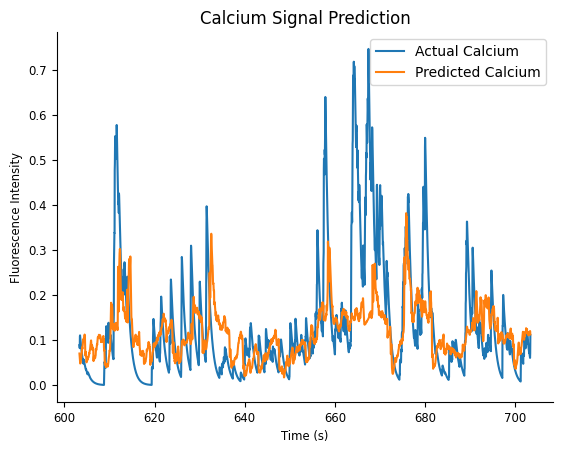

In [20]:
ep_to_plot = nap.IntervalSet(testing_ep.start[0], testing_ep.start[0] + 100)  # Plot first 10 seconds of test epoch

fig = plt.figure()
plt.plot(transients.restrict(ep_to_plot)[:,0], label="Actual Calcium")
plt.plot(calcium_predicted.restrict(ep_to_plot)[:,0], label="Predicted Calcium")
plt.legend()
plt.title("Calcium Signal Prediction")
plt.xlabel("Time (s)")
plt.ylabel("Fluorescence Intensity")

In [21]:
fig.savefig("../../_static/_check_figs/02-12.png")

<div class="render-user">
:::{admonition} Figure check
:class: dropdown
![](../../_static/_check_figs/02-12.png)
:::
</div>

<div class="render-all">

Similar to the spike data, we can extract and visualize the coupling filters between neurons based on the fitted model.
</div>

In [22]:
# split the coefficient vector along the feature axis (axis=0)
calcium_weights_dict = calcium_basis.split_by_feature(calcium_model.coef_, axis=0)
# The output is a dict with key the basis label, 
# and value the reshaped coefficients
calcium_weights = calcium_weights_dict["RaisedCosineLogConv"]
# reconstruct the coupling filters
time, basis_kernels = calcium_basis.evaluate_on_grid(calcium_window_size)
calcium_responses = np.einsum("jki,tk->ijt", calcium_weights, basis_kernels)
print(calcium_responses.shape)

(16, 16, 14)


We can use the same plotting function as before to visualize the coupling filters for the calcium data.

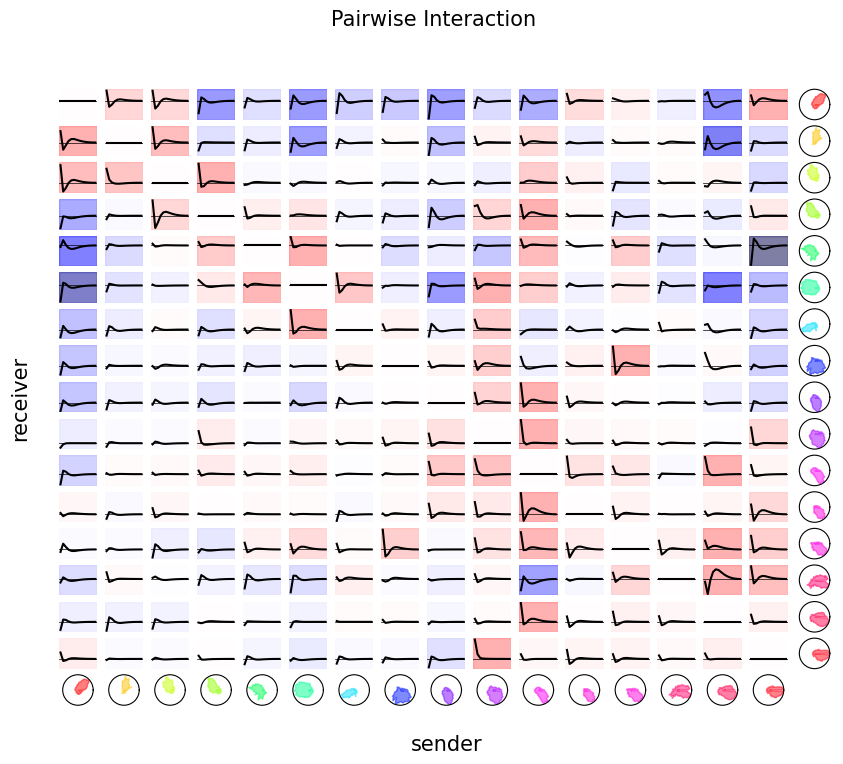

In [23]:
fig = workshop_utils.plot_coupling_filters(calcium_responses, tuning_curves)

In [24]:
fig.savefig("../../_static/_check_figs/02-13.png")

<div class="render-user">
:::{admonition} Figure check
:class: dropdown
![](../../_static/_check_figs/02-13.png)
:::
</div>


<div class="render-all">

These coupling filters represent the functional relationships between neurons based on their calcium signal.
Note that the slower dynamics of calcium signals may lead to different coupling patterns compared to spike data.

The end of this group project. You can explore further by trying different basis functions, regularization strengths, or observation models.
You can also try to incorporate external covariates, such as the head-direction signal, into the model.
You can try to downsample the data to see how it affects the model fitting and predictions (i.e. check `bin_average` in pynapple to downsample the transients).

</div>